In [36]:
import JSSP
import time
import numpy as np
import random
import gym
import itertools
import numpy as np
import matplotlib
import matplotlib.style
import pandas as pd
import sys


from collections import defaultdict
#import plotting

# Environment Initialization

In [37]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [38]:
env1 = create_env("instance1.txt")
env3 = create_env("instance3.txt")
env4 = create_env("instance4.txt")

Environment Created for:  instance1.txt
Observation space: 
 Box([-2 -2  0  0], [2 2 2 2], (4,), int64)
Action space: 
 Discrete(8)
Environment Created for:  instance3.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9], (20,), int64)
Action space: 
 Discrete(260)
Environment Created for:  instance4.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5], (20,), int64)
Action space: 
 Discrete(756)


# Baselines

## 1. Random Sampling

In [42]:
def random_sampling(env, episodes):
    env.reset()
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    for episode in range(1, episodes+1):
        env.reset()
        done = False
        score = 0
        action_list = []
        time_list = []
        while not done:
            #env.render()
            action = env.action_space.sample()
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                # print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            n_state, reward, done, info = env.step(action)
            score+=reward
        print('Episode:{} Total_reward:{}'.format(episode, score))
        if score >= max_score:
            max_score = score
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

random_sampling(env1, 100)

Episode:1 Total_reward:-72
Episode:2 Total_reward:-77
Episode:3 Total_reward:-73
Episode:4 Total_reward:-61
Episode:5 Total_reward:-62
Episode:6 Total_reward:-66
Episode:7 Total_reward:-67
Episode:8 Total_reward:-76
Episode:9 Total_reward:-66
Episode:10 Total_reward:-71
Episode:11 Total_reward:-80
Episode:12 Total_reward:-74
Episode:13 Total_reward:-59
Episode:14 Total_reward:-70
Episode:15 Total_reward:-55
Episode:16 Total_reward:-70
Episode:17 Total_reward:-78
Episode:18 Total_reward:-75
Episode:19 Total_reward:-65
Episode:20 Total_reward:-76
Episode:21 Total_reward:-59
Episode:22 Total_reward:-76
Episode:23 Total_reward:-66
Episode:24 Total_reward:-65
Episode:25 Total_reward:-71
Episode:26 Total_reward:-73
Episode:27 Total_reward:-77
Episode:28 Total_reward:-75
Episode:29 Total_reward:-65
Episode:30 Total_reward:-75
Episode:31 Total_reward:-76
Episode:32 Total_reward:-66
Episode:33 Total_reward:-62
Episode:34 Total_reward:-64
Episode:35 Total_reward:-53
Episode:36 Total_reward:-71
E

## 2. Q-Learning

In [43]:
# def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
# 	"""
# 	Creates an epsilon-greedy policy based
# 	on a given Q-function and epsilon.
#
# 	Returns a function that takes the state
# 	as an input and returns the probabilities
# 	for each action in the form of a numpy array
# 	of length of the action space(set of possible actions).
# 	"""
def policy(state, Q, epsilon, num_actions):

    if state in Q:
        best_action = np.argmax(Q[state])
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    Action_probabilities = np.ones(num_actions, dtype = float) / num_actions
    return Action_probabilities

In [44]:
def update(Q, state, next_state, action, reward, eta, gamma):

    if next_state not in Q:
        Q_next_state_max = -1
    else:
        Q_next_state_max = max(Q[next_state])

    Q[state][action] = Q[state][action] + eta * (reward + gamma * Q_next_state_max - Q[state][action])

    return Q

In [47]:
def q_learning(env, epis):

    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []

    # 1. Load Environment and Q-table structure
    Q_table = {}
    # 2. Parameters of Q-learning
    eta = .628
    gamma = 1
    epsilon = .1
    decay_rate = .0001
    total_reward_list = [] # rewards per episode calculate
    # 3. Q-learning Algorithm
    for episode in range(epis):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        action_list = []
        time_list = []

        # The Q-Table learning algorithm
        while not done:
            if epsilon >= decay_rate:
                epsilon -= decay_rate
            if state not in Q_table:
                Q_table[state] = np.zeros(env.action_space.n)
            action_probabilities = policy(state, Q_table, epsilon, env.action_space.n)
            action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                #print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            #Get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            #Update Q-Table with new knowledge
            Q_table = update(Q_table, state, next_state, action, reward, eta, gamma)
            if eta > .01:
                eta -= decay_rate
            total_reward += reward
            state = next_state
        total_reward_list.append(total_reward)
        if total_reward >= max_score:
            max_score = total_reward
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
        print("Episode: " + str(episode) + " has time " + str(env.time))

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table

print()
total_reward_list, Q_table = q_learning(env1, 100)


Episode: 0 has time 60
Episode: 1 has time 75
Episode: 2 has time 83
Episode: 3 has time 66
Episode: 4 has time 71
Episode: 5 has time 70
Episode: 6 has time 62
Episode: 7 has time 61
Episode: 8 has time 60
Episode: 9 has time 75
Episode: 10 has time 101
Episode: 11 has time 60
Episode: 12 has time 75
Episode: 13 has time 66
Episode: 14 has time 65
Episode: 15 has time 60
Episode: 16 has time 60
Episode: 17 has time 71
Episode: 18 has time 70
Episode: 19 has time 62
Episode: 20 has time 62
Episode: 21 has time 66
Episode: 22 has time 58
Episode: 23 has time 63
Episode: 24 has time 73
Episode: 25 has time 64
Episode: 26 has time 75
Episode: 27 has time 64
Episode: 28 has time 69
Episode: 29 has time 67
Episode: 30 has time 58
Episode: 31 has time 84
Episode: 32 has time 64
Episode: 33 has time 65
Episode: 34 has time 78
Episode: 35 has time 69
Episode: 36 has time 63
Episode: 37 has time 70
Episode: 38 has time 72
Episode: 39 has time 89
Episode: 40 has time 84
Episode: 41 has time 86


<function matplotlib.pyplot.show(close=None, block=None)>

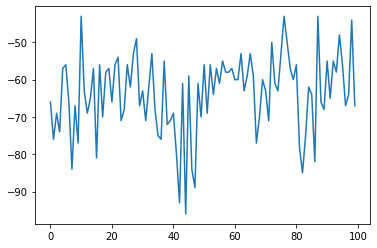

In [35]:
import matplotlib.pyplot as plt
plt.plot(total_reward_list)
plt.show


In [ ]:
plt.plot(total_reward_list)
plt.show

In [ ]:
print(Q_table)

## DQN

In [ ]:
from stable_baselines3 import DQN

model = DQN("MlpPolicy", env1, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("dqn_cartpole")

del model # remove to demonstrate saving and loading

model = DQN.load("dqn_cartpole")

obs = env1.reset()
for episode in range(500):
    env1.reset()
    total_reward = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env1.step(action)
        total_reward += reward
    print("Episode: " + str(episode) + " has reward " + str(total_reward))
        # env.render()

## Q Learning from web

In [ ]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions, env):
	"""
	Creates an epsilon-greedy policy based
	on a given Q-function and epsilon.

	Returns a function that takes the state
	as an input and returns the probabilities
	for each action in the form of a numpy array
	of length of the action space(set of possible actions).
	"""
	def policyFunction(state):

		Action_probabilities = np.ones(num_actions,
				dtype = float) * epsilon / num_actions

		best_action = np.argmax(Q[state])
		Action_probabilities[best_action] += (1.0 - epsilon)
		return Action_probabilities

	return policyFunction

In [ ]:
def qLearning(env, num_episodes, discount_factor = 1.0,
							alpha = 0.6, epsilon = 0.1):
	"""
	Q-Learning algorithm: Off-policy TD control.
	Finds the optimal greedy policy while improving
	following an epsilon-greedy policy"""

	# Action value function
	# A nested dictionary that maps
	# state -> (action -> action-value).
	Q = defaultdict(lambda: np.zeros(env.action_space.n))

	# Keeps track of useful statistics
	stats = {
            "episode_lengths" : np.zeros(num_episodes),
		    "episode_rewards" : np.zeros(num_episodes)}

	# Create an epsilon greedy policy function
	# appropriately for environment action space
	policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n, env)

	# For every episode
	for ith_episode in range(num_episodes):

		# Reset the environment and pick the first action
		state = env.reset()

		for t in itertools.count():

			# get probabilities of all actions from current state
			action_probabilities = policy(state)

			# choose action according to
			# the probability distribution
			action = np.random.choice(np.arange(
					len(action_probabilities)),
					p = action_probabilities)

			# take action and get reward, transit to next state
			next_state, reward, done, _ = env.step(action)

			# Update statistics
			stats["episode_rewards"][ith_episode] += reward
			stats["episode_lengths"][ith_episode] = t

			# TD Update
			best_next_action = np.argmax(Q[next_state])
			td_target = reward + discount_factor * Q[next_state][best_next_action]
			td_delta = td_target - Q[state][action]
			Q[state][action] += alpha * td_delta

			# done is True if episode terminated
			if done:
				break

			state = next_state

	return Q, stats